In [114]:
# Packages
import numpy as np
from scipy.sparse import coo_matrix, csc_matrix, find, csr_array
import matplotlib.pyplot as plt
from scipy.sparse.linalg import lsqr

# 1 Constructing the matrix X
"As in real-world scenarios, there is some ambiguity left to this task: Where is the origin of the coordinate system, which direction is α = 0, and how is y oriented?" 
We identify the answers to these questions by expanding the required function `construct_X(M, alphas, Np=None` to also have `origin`, `alpha_zero_direction` and `y_orientation` parameters for comparison.

In [135]:
def construct_X(M, alphas, Np=None, origin='center', alpha_zero_direction='y'):
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
    
    D = M * M
    N = len(alphas) * Np
    
    # Create grid of pixel centers using numpy.mgrid
    xv, yv = np.mgrid[0:M, 0:M]
    pixel_centers = np.vstack((xv.ravel(), yv.ravel()))  # shape: (2, D)
    
    # Adjust origin if provided
    if origin == 'center':
        pixel_centers[0] -= (M - 1) // 2
        pixel_centers[1] -= (M - 1) // 2
    
    # Initialize lists to store the indices and weights
    i_indices = []
    j_indices = []
    weights = []
    
    # Convert degrees to radians for trigonometric functions
    alphas = np.deg2rad(alphas)
    
    for io, alpha in enumerate(alphas):
        # Adjust alpha with the base direction
        if alpha_zero_direction == 'y':
            adjusted_alpha = alpha + np.pi / 2
        else: 
            adjusted_alpha = alpha
        cos_alpha = np.cos(adjusted_alpha)
        sin_alpha = np.sin(adjusted_alpha)
        
        # Project pixel centers onto the rotated sensor array
        n = np.array([cos_alpha, sin_alpha])
        projections = n @ pixel_centers
        
        # Shift projections to sensor indices (assuming sensor elements are centered around 0)
        sensor_positions = projections + (Np - 1) / 2
        
        # Determine which sensor elements the projections fall between
        sensor_indices = np.floor(sensor_positions).astype(int)
        sensor_fractions = sensor_positions - sensor_indices
        
        # Handle boundaries: if sensor_indices is out of range, skip those projections
        valid_indices = (sensor_indices >= 0) & (sensor_indices < Np - 1)
        
        sensor_indices = sensor_indices[valid_indices]
        sensor_fractions = sensor_fractions[valid_indices]
        pixel_indices = np.arange(D)[valid_indices]
        
        # Weight contributions for the two closest sensor elements
        w1 = 1 - sensor_fractions
        w2 = sensor_fractions
        
        # set indicies for horizontal y
        i_indices.extend(sensor_indices + Np * io)
        i_indices.extend(sensor_indices + 1 + Np * io)
        
        j_indices.extend(pixel_indices)
        j_indices.extend(pixel_indices)
        weights.extend(w1)
        weights.extend(w2)
    
    # Convert to numpy arrays
    i_indices = np.array(i_indices)
    j_indices = np.array(j_indices)
    weights = np.array(weights)
    
    # Create sparse matrix
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype=np.float32)
    
    return X

Sketch different parameters to find appropriate matrix construction.

In [136]:
M = 10 
alphas = [-33, 1, 42]

X1 = construct_X(M, alphas, origin='center', alpha_zero_direction='x').toarray()
X2 = construct_X(M, alphas, origin='center', alpha_zero_direction='y').toarray()
X3 = construct_X(M, alphas, origin='top-left', alpha_zero_direction='x').toarray()
X4 = construct_X(M, alphas, origin='top-left', alpha_zero_direction='y').toarray()

X_example = np.load('hs_tomography/X_example.npy')

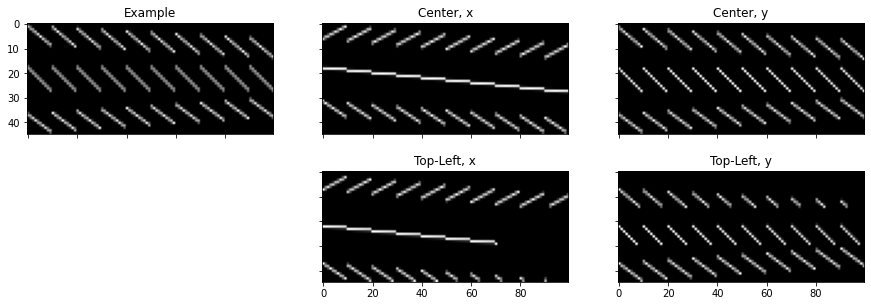

In [137]:
fig, axs = plt.subplots(2, 3, figsize=(15, 5))

axs[0, 0].imshow(X_example, cmap='gray')
axs[0, 0].set_title('Example')
axs[0, 1].imshow(X1, cmap='gray')
axs[0, 1].set_title('Center, x')
axs[0, 2].imshow(X2, cmap='gray')
axs[0, 2].set_title('Center, y')
fig.delaxes(axs[1,0])
axs[1, 1].imshow(X3, cmap='gray')
axs[1, 1].set_title('Top-Left, x')
axs[1, 2].imshow(X4, cmap='gray')
axs[1, 2].set_title('Top-Left, y')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

Clearly, `origin=center` and `alpha_zero_direction=y` give an appropriate matrix. These were updated to run as defaults in the function.

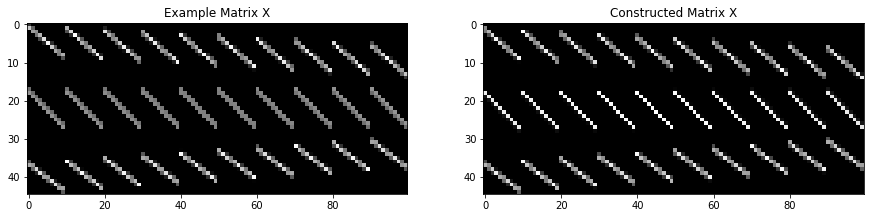

In [138]:
# Construct the matrix X
M = 10 
alphas = [-33, 1, 42]
X = construct_X(M, alphas)

# Final visualisation
X_example = np.load('hs_tomography/X_example.npy')
X_dense = X.toarray()

plt.figure(figsize=(15, 15))

plt.subplot(1, 2, 2)
plt.imshow(X_dense, cmap='gray')
plt.title("Constructed Matrix X")

plt.subplot(1, 2, 1)
plt.imshow(X_example, cmap='gray')
plt.title("Example Matrix X")

plt.show()

<div style="color: green; font-weight: bold">
- The construct_X function is very similar to the one from the sample solutions. To resolve the mentioned ambiguities in the task, they extended the parameter list of the function.
<br>
- In the end, they correctly construct the matrix X, which can also be seen in the last plot above.
</div>

# 2 Recovering the image
Exactly how many non-zero entries does X have? Use scipy's tools to find out and report the sparsity of X:

In [139]:
def report_sparcity(X):
    # Calculate the number of non-zero entries
    num_nonzero = len(find(csr_array(X))[0])
    total_entries = X.shape[0] * X.shape[1]
    sparsity = num_nonzero / total_entries

    return num_nonzero, sparsity

In [140]:
def reconstruct_image(X, y, M, atol, btol):
    beta = lsqr(X, y, atol=atol, btol=btol)
    if beta[1]==1:
        print("approximate solution found.")
    elif beta[1]==2:
        print("beta approximately solves the solution.")
    else:
        print("Termination without approximate solution.")
    
    return beta[0].reshape(M, M)

In [160]:
M = 77
Np = 109
alphas = np.load("hs_tomography/alphas_77.npy")
y_short=np.load("hs_tomography/y_77.npy")
X_short = construct_X(M, alphas, Np).toarray()

nonzero, sparcity = report_sparcity(X_short)
print(f"For M=77 X has {nonzero} nonzero entries and sparcity {sparcity}")

For M=77 X has 1066992 nonzero entries and sparcity 0.01834470386835453


<div style="color: green; font-weight: bold">
- Sparcity is almost correctly computed. The current solution computes actually the density of the matrix.
</div>

In [161]:
atol=btol = 1e-05
my_short = reconstruct_image(X_short, y_short, M, atol, btol)

approximate solution found.


Apparently istop 7 means that lsqr was terminated, because the iteraion limit was reached.

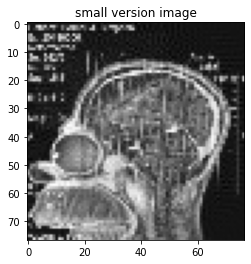

In [162]:
plt.imshow(my_short,cmap="gray")
plt.title("small version image")
plt.show()

### Now with X_77 from file

In [144]:
M = 77
Np = 109
alphas = np.load("hs_tomography/alphas_77.npy")
y_short = np.load("hs_tomography/y_77.npy")
X_77 = np.load("hs_tomography/X_77.npy", allow_pickle=True)

In [145]:
atol=btol = 1e-08
sample_short = reconstruct_image(X_77.tolist(), y_short, M, atol, btol)

approximate solution found.


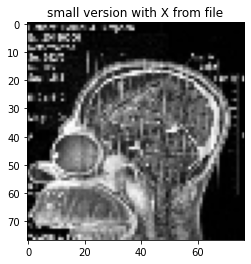

In [146]:
plt.imshow(sample_short, cmap='gray')
plt.title("small version with X from file")
plt.show()

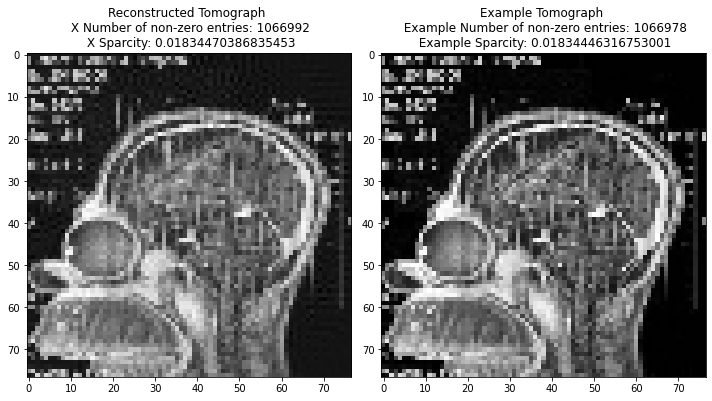

In [147]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.imshow(my_short, cmap='gray')
nonzero, sparcity = report_sparcity(X_short)
plt.title(f"Reconstructed Tomograph \n X Number of non-zero entries: {nonzero}\n X Sparcity: {sparcity}")

plt.subplot(1, 2, 2)
plt.imshow(sample_short, cmap='gray')
nonzero, sparcity = report_sparcity(X_77.tolist())
plt.title(f"Example Tomograph \n Example Number of non-zero entries: {nonzero}\n Example Sparcity: {sparcity}")

plt.tight_layout()
plt.show()

<div style="color: green; font-weight: bold">
- The reconstructed tomogram is quite similar to the example tomogram.
<br>
- The small differences might arise from the fact that atol and btol were set to 1e-5 for the reconstruction with the matrix "X_short" and they were set to 1e-8 for the reconstruction with the matrix "X_77" (provided matrix).
<br>
- The scipy.sparse 's least squares solver was correcly used for reconstruction.
</div>

### Larger data

In [150]:
# Parameters:
M = 195
Np = 275
angles = np.load('hs_tomography/alphas_195.npy')
y = np.load('hs_tomography/y_195.npy')
atol=btol = 1e-08   # high atol and btol

# Construct matrix and reconstruct image
X = construct_X(M, angles, Np)
X_tomogram = reconstruct_image(X, y, M, atol, btol)

Termination without approximate solution.


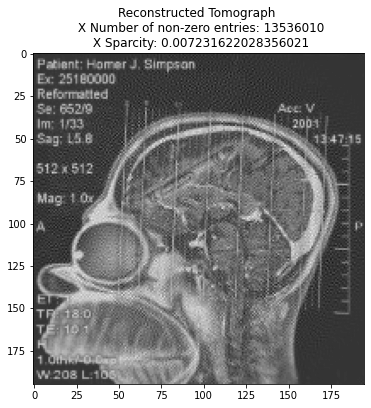

In [151]:
# Output image
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.imshow(X_tomogram, cmap='gray')
X_ent, X_spar = report_sparcity(X)
plt.title(f"Reconstructed Tomograph \n X Number of non-zero entries: {X_ent}\n X Sparcity: {X_spar}")
plt.tight_layout()
plt.show()

### Give a diagnosis on what causes H.S.'s headache and propose a treatment

The patients headache appears to be caused by a crayon, which has been lodged in his brain since they were a child, due to shoveing them up his nose. This can be alleviated by surgically removing the crayon, this may either cause death or come with the side effect of increased intelligence.

<div style="color: green; font-weight: bold">
- Tomogram obtained from the larger data looks correct.
<br>
- Diagnosis and treatment are correct.
</div>

# 3 Minimizing the radiation dose

We can select a symmetric Subset of angles to reduce the number of projection angles.

approximate solution found.
approximate solution found.
approximate solution found.
approximate solution found.
approximate solution found.
approximate solution found.


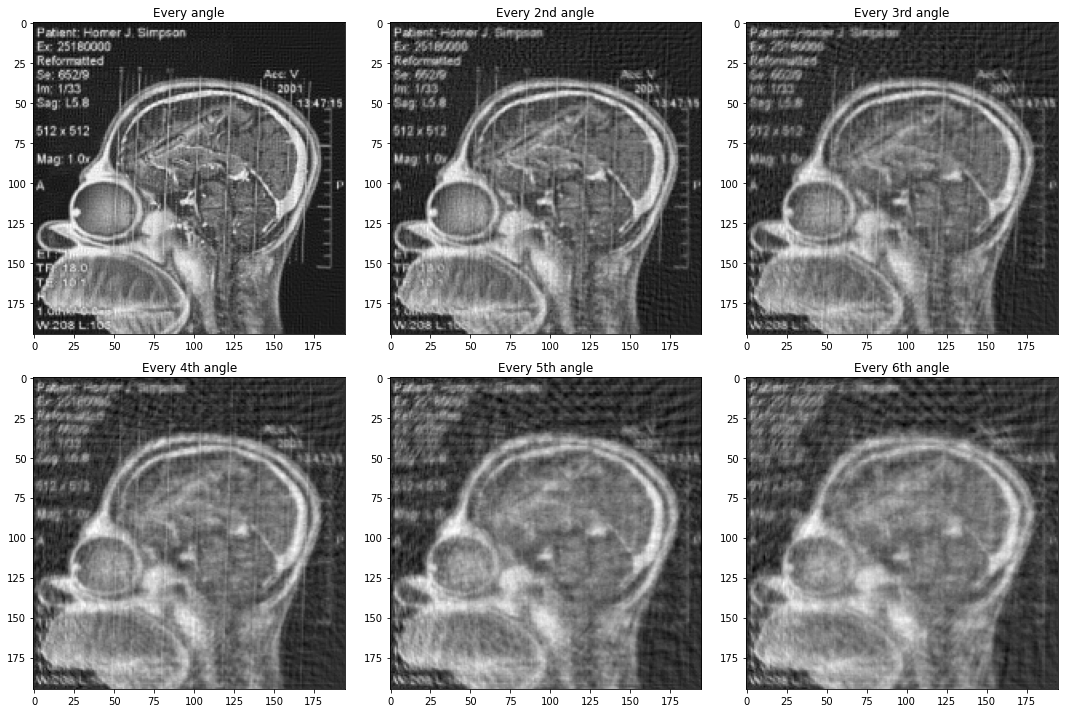

In [193]:
# Parameters
M = 195
Np = 275
alphas = np.load('hs_tomography/alphas_195.npy')
y = np.load('hs_tomography/y_195.npy')
atol=btol = 1e-05

s = [2, 3, 4, 5, 6]
angle_subsets = [alphas, alphas[::s[0]], alphas[::s[1]], alphas[::s[2]], alphas[::s[3]], alphas[::s[4]]]  # Every 2nd, 3rd, 4th, and 5th angle
y_subsets = [y, y.reshape(-1, Np)[::s[0]].flatten(), y.reshape(-1, Np)[::s[1]].flatten(), y.reshape(-1, Np)[::s[2]].flatten(), y.reshape(-1, Np)[::s[3]].flatten(), y.reshape(-1, Np)[::s[4]].flatten()]
subset_labels = ['Every angle', f'Every 2nd angle', f'Every {s[1]}rd angle', f'Every {s[2]}th angle', f'Every {s[3]}th angle', f'Every {s[4]}th angle']

plt.figure(figsize=(15, 10))

for i, subset in enumerate(angle_subsets):
    X = construct_X(M, subset, Np)
    tomogram = reconstruct_image(X, y_subsets[i], M, atol, btol)
    plt.subplot(2, 3, i+1)
    plt.imshow(tomogram, cmap='gray')
    plt.title(subset_labels[i])

plt.tight_layout()
plt.show()

###  In the case of H.S., what would you say is the minimal number of projections that still allows you to resolve the cause of his headache?
Based on the above comparison, It is still visible that there is a foreign object lodges in his brain useing every 4th angle, however to identify it as a crayon specifically we would want to take a minimum of every 3rd angle. This means the minimum number of projections is a quarter or a third of the original, depending on whether a general prognosis (i.e. "there is some foreign object) is sufficient.

<div style="color: green; font-weight: bold">
- Analysis of the minimal number of projections was approached differently than in the sample solution: in the current solution, the selection period of the angle is always increased (and therefore less and less projections are used), whereas in the sample solution the number of used projections is always increased (starting from 1 and ending with 64).
<br>
- The conclusions are similar. In the current solution, they say that by taking every 4th angle (i.e. ca. 44 angles are used), the reconstructed image shows the presence of a foreign object. However, to better identify the object, they propose taking every third angle (i.e. ca. 59 angles are used).
</div>